> ## ⚠️ Important Lab Disclaimer
> This lab requires API keys (OpenAI, Tavily, OpenWeather) if you want to run the live examples.  
> These keys stay only inside the **temporary Udemy lab workspace** and are **not persisted or shared**, but you should still treat them like any other secret.  
> Use your own discretion when entering keys, and feel free to **revoke or rotate** them after the lab.  
> If you prefer **not** to use real API keys, Copy paste away or download the notebook and run it locally.


This script securely collect API key (`OPENAI_API_KEY`) using `getpass` so your input is hidden.  
It then creates/overwrites a `.env` file and writes each key as `NAME=value` on its own line.  
Finally, it prints **“Saved .env”** when finished.


In [ ]:
from getpass import getpass

names = ["OPENAI_API_KEY"]
with open(".env", "w", encoding="utf-8") as f:
    for n in names:
        f.write(f"{n}={getpass(f'Enter {n}: ').strip()}\n")
print("Saved .env")


This code locates the nearest `.env` file in the current working directory (using `find_dotenv`) and loads its key–value pairs into the environment (using `load_dotenv`).  
It does **not** overwrite any existing environment variables because `override=False`.


In [ ]:
from dotenv import load_dotenv, find_dotenv
env_path = find_dotenv(usecwd=True)
load_dotenv(env_path, override=False)

In [1]:
from typing import TypedDict, Literal

from IPython.display import Image, display

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.messages import AIMessage, SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI


In [2]:

chat = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

This code defines a tiny LangGraph app where `MiniState` holds a `prompt` and `response`. The `call_model` node sends the prompt to `chat.invoke`, stores the model’s reply in `response`, and the `StateGraph` wires a simple flow: START → `call_model` → END. `mini_app = g.compile()` builds the runnable graph, `get_graph().draw_mermaid_png()` shows its diagram, and `mini_app.invoke({...})` runs the graph once with a New York trip prompt and prints the model’s answer.


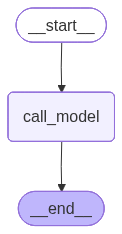

For Day 1 in New York, I would suggest starting the evening by heading to Times Square to experience the bright lights and bustling atmosphere of this iconic location. Take a leisurely stroll through the area and maybe grab a quick bite to eat at one of the many restaurants or food carts.

After exploring Times Square, consider catching a Broadway show at one of the nearby theaters. There are always a variety of shows to choose from, ranging from classic musicals to cutting-edge dramas.

If theater isn't your thing, you could also head to a rooftop bar for a drink with a view of the city skyline. There are plenty of options to choose from, each offering a unique perspective of the city at night.

To end the evening, take a walk along the High Line, a unique elevated park built on a historic freight rail line. The park offers stunning views of the city and is a peaceful way to wind down after a busy day of exploring.


In [3]:
class MiniState(TypedDict):
    prompt: str
    response: str

def call_model(state: MiniState) -> MiniState:
    output = chat.invoke(state["prompt"])  
    return {
        "prompt": state["prompt"],        
        "response": output.content        
    }

g = StateGraph(MiniState)
g.add_node("call_model", call_model)
g.add_edge(START, "call_model")
g.add_edge("call_model", END)  
mini_app = g.compile() 

display(Image(mini_app.get_graph().draw_mermaid_png()))

result = mini_app.invoke({"prompt": "Suggest an evening plan for Day 1 in New York."})
print(result["response"])

Continuing the same pattern, this example creates a second LangGraph app using a richer `TripState` with fields like `city`, `days`, `group`, and `budget`. The `plan_trip` node builds a prompt from the state, calls the LLM, and returns the same state plus an `answer` containing the generated itinerary. The graph flow is still START → `plan_trip` → END. After compiling, `travel_planner.invoke({...})` runs the trip-planning workflow and prints the LLM’s itinerary.


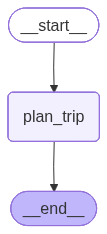

Day 1:
Morning: Arrive in New York and check into a family-friendly hotel in Midtown Manhattan.
Afternoon: Visit Times Square and explore the shops and attractions. Have lunch at a nearby restaurant.
Evening: Take a stroll through Central Park and enjoy a picnic dinner.

Day 2:
Morning: Start the day with a visit to the Statue of Liberty and Ellis Island. Take a ferry ride to see these iconic landmarks up close.
Afternoon: Head to the American Museum of Natural History and spend the afternoon exploring the exhibits and interactive displays.
Evening: Enjoy a Broadway show in the Theater District. Have dinner at a family-friendly restaurant before heading back to the hotel for the night.

Overall, this 2-day trip to New York offers a mix of iconic landmarks, cultural experiences, and family-friendly activities within a mid-range budget.


In [4]:
class TripState(TypedDict, total=False):
    city: str
    days: int
    group: str               
    budget: Literal["budget", "mid", "premium"]
    answer: str    

def plan_trip(state: TripState) -> TripState:
    
    prompt = (
        f"Plan a {state['days']}-day trip to {state['city']} for {state['group']}.\n"
        f"Budget: {state['budget']}. Return an itinerary with Day1/Day2... and morning/afternoon/evening plans."
    )
    output = chat.invoke(prompt)
    return { **state, "answer": output.content } 


g2 = StateGraph(TripState)
g2.add_node("plan_trip", plan_trip)
g2.add_edge(START, "plan_trip")
g2.add_edge("plan_trip", END)
travel_planner = g2.compile()
display(Image(travel_planner.get_graph().draw_mermaid_png()))    

result = travel_planner.invoke({
    "city": "New York",
    "days": 2,
    "group": "2 adults + 2 kids",
    "budget": "mid"
})
print(result["answer"])

Here we reuse the same `MiniState` graph pattern from above.


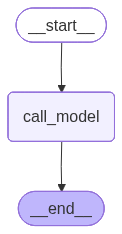

In [5]:

class MiniState(TypedDict):
    prompt: str
    response: str

def call_model(state: MiniState) -> MiniState:
    output = chat.invoke(state["prompt"]) 
    return {
        "prompt": state["prompt"],        
        "response": output.content        
    }

g = StateGraph(MiniState)
g.add_node("call_model", call_model)
g.add_edge(START, "call_model")  
g.add_edge("call_model", END)    
mini_app = g.compile()           
display(Image(mini_app.get_graph().draw_mermaid_png()))

Next, we actually run the compiled `mini_app`: `invoke({...})` passes a specific NYC trip prompt into the START → `call_model` → END graph, and we print the LLM’s generated itinerary from `first["response"]`.


In [7]:
first = mini_app.invoke({"prompt": f"Write an evening NYC itinerary for 2 days and 1 night for a couple and 2 kids. "})
print(first["response"])

Day 1:
- Arrive in NYC in the afternoon and check into your hotel in Midtown Manhattan.
- Head to Times Square to take in the bright lights and bustling atmosphere.
- Have dinner at a family-friendly restaurant in the area, such as Ellen's Stardust Diner.
- Walk to Rockefeller Center to see the famous ice skating rink and take a ride to the Top of the Rock for stunning views of the city.
- End the evening with a visit to the nearby Nintendo Store for some fun shopping.

Day 2:
- Start the day with breakfast at a local diner or cafe.
- Take a stroll through Central Park and visit the Central Park Zoo.
- Head to the American Museum of Natural History to explore the exhibits and see the famous dinosaur skeletons.
- Have lunch at a nearby restaurant or food truck.
- In the afternoon, take a ferry to the Statue of Liberty and Ellis Island for a historical and educational experience.
- Return to Manhattan and have dinner at a family-friendly restaurant in the area.
- End the evening with a B

Here we send a follow-up prompt to the **same one-shot graph**, but because `MiniState` does **not** store prior messages or context, the LLM has no memory of the first itinerary. As a result, `mini_app.invoke()` often hallucinates or rewrites details incorrectly—demonstrating why stateful message history is needed for reliable follow-ups.


In [8]:
followup = (
    "Revise the previous itinerary. Keep EVERYTHING the same and  Only change Day 2 to add a morning in long island with pizza for lunch."
)
naive = mini_app.invoke({"prompt": followup})
print(naive["response"])

Day 1:
- Morning: Visit Central Park and have a picnic lunch
- Afternoon: Explore the Museum of Modern Art
- Evening: Dinner in Times Square

Day 2:
- Morning: Spend the morning in Long Island and enjoy some delicious pizza for lunch
- Afternoon: Visit the Statue of Liberty and Ellis Island
- Evening: Dinner in Little Italy

Day 3:
- Morning: Explore the Metropolitan Museum of Art
- Afternoon: Walk across the Brooklyn Bridge and explore Brooklyn Heights
- Evening: Dinner in Chinatown


Now we switch to `MessagesState`, where the graph state is a list of chat messages. The `llm_turn` node sends `state["messages"]` to the LLM and returns the reply as a new message list. We again build a simple START → `llm_turn` → END graph, compile it as `conversation_agent`, and render its one-turn “chat agent” diagram.


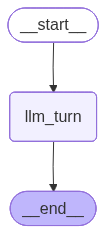

In [10]:
def llm_turn(state: MessagesState):
    reply = chat.invoke(state["messages"])  
    return {"messages": [reply]}

conv_graph = StateGraph(MessagesState)
conv_graph.add_node("llm_turn", llm_turn)
conv_graph.add_edge(START, "llm_turn")
conv_graph.add_edge("llm_turn", END)
conversation_agent = conv_graph.compile()

display(Image(conversation_agent.get_graph().draw_mermaid_png()))

We run `conversation_agent` with an initial history (system + user message). The graph produces one LLM reply, and we print the assistant’s itinerary from the last `messages` entry.


In [11]:
history = [
    SystemMessage(content="You are a concise travel planner."),
    HumanMessage(content="Write a 1-day NYC itinerary.")
]
result1 = conversation_agent.invoke({"messages": history})
print(result1["messages"][-1].content)

Morning:
- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.
- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.

Afternoon:
- Grab lunch at a local deli or food truck, then make your way to Times Square to experience the bustling energy of this iconic intersection.
- Visit the Empire State Building for panoramic views of the city from the observation deck.

Evening:
- Enjoy dinner in the trendy neighborhood of Chelsea or Greenwich Village.
- End your day with a Broadway show in the Theater District for a memorable evening of entertainment.


In [12]:
result1

{'messages': [SystemMessage(content='You are a concise travel planner.', additional_kwargs={}, response_metadata={}, id='ac881dd9-11dc-4ff9-ac39-2770a62639c5'),
  HumanMessage(content='Write a 1-day NYC itinerary.', additional_kwargs={}, response_metadata={}, id='be0c686f-5f25-457d-ade8-68ea270f6ecd'),
  AIMessage(content="Morning:\n- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.\n- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.\n\nAfternoon:\n- Grab lunch at a local deli or food truck, then make your way to Times Square to experience the bustling energy of this iconic intersection.\n- Visit the Empire State Building for panoramic views of the city from the observation deck.\n\nEvening:\n- Enjoy dinner in the trendy neighborhood of Chelsea or Greenwich Village.\n- End your day with a Broadway show in the Theater District for a m

For the follow-up, we append a new human message to the prior history with `add_messages`, then invoke the same graph again. Because the full conversation is preserved in `messages`, the LLM can give a grounded, rain-specific indoor plan that stays consistent with the original itinerary.


In [13]:
followup = HumanMessage(content="What to do if it rains? Suggest an indoor plan.")
next_input = { "messages": add_messages(result1["messages"], followup) }
result2 = conversation_agent.invoke(next_input)
print(result2["messages"][-1].content)

If it rains in NYC, here is an indoor plan for a day:

Morning:
- Start your day with a visit to the American Museum of Natural History. Explore fascinating exhibits on dinosaurs, space, and more.
- Grab brunch at a cozy cafe or restaurant nearby.

Afternoon:
- Head to the Metropolitan Museum of Art to admire a vast collection of art spanning thousands of years and cultures.
- Visit the Oculus at the World Trade Center for some shopping and to marvel at the stunning architecture.

Evening:
- Have dinner at a trendy restaurant in SoHo or the Lower East Side.
- Catch a performance at the Lincoln Center for the Performing Arts, such as a ballet, opera, or concert.


In [14]:
result2["messages"]

[SystemMessage(content='You are a concise travel planner.', additional_kwargs={}, response_metadata={}, id='ac881dd9-11dc-4ff9-ac39-2770a62639c5'),
 HumanMessage(content='Write a 1-day NYC itinerary.', additional_kwargs={}, response_metadata={}, id='be0c686f-5f25-457d-ade8-68ea270f6ecd'),
 AIMessage(content="Morning:\n- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.\n- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.\n\nAfternoon:\n- Grab lunch at a local deli or food truck, then make your way to Times Square to experience the bustling energy of this iconic intersection.\n- Visit the Empire State Building for panoramic views of the city from the observation deck.\n\nEvening:\n- Enjoy dinner in the trendy neighborhood of Chelsea or Greenwich Village.\n- End your day with a Broadway show in the Theater District for a memorable evenin

To make this chat truly stateful across runs, we plug in a `MemorySaver` checkpoint. Recompiling with `checkpointer=memory` means each `conversation_agent.invoke(...)` saves and reloads the `MessagesState` by thread ID, so multi-turn chats can resume later with full history instead of starting from scratch.


In [15]:

memory = MemorySaver()
conversation_agent = conv_graph.compile(checkpointer=memory)

Now we run the memory-backed agent with a `config` that sets `thread_id = "1"`. The initial system + user messages start a new saved conversation thread, and we print the AI’s first itinerary reply.


In [16]:
config = {"configurable": {"thread_id": "1"}}

history = [
    SystemMessage(content="You are a concise travel planner."),
    HumanMessage(content="Write a 1-day NYC itinerary.")
]

result1 = conversation_agent.invoke({"messages": history},config)
print(result1["messages"][-1].content)  # last message (AI's answer)

Morning:
- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.
- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.

Lunch:
- Grab a bite to eat at a local deli or food truck in Midtown Manhattan.

Afternoon:
- Walk down Fifth Avenue to see the famous luxury shops and department stores.
- Visit the Empire State Building for panoramic views of the city from the observation deck.

Evening:
- Have dinner in Times Square, known for its bright lights and bustling atmosphere.
- Catch a Broadway show at one of the many theaters in the area.

Late Night:
- End your day with a nightcap at a rooftop bar overlooking the city skyline.


In [17]:
result1

{'messages': [SystemMessage(content='You are a concise travel planner.', additional_kwargs={}, response_metadata={}, id='579de5d4-c4bf-4c5b-9bac-769e4f215d91'),
  HumanMessage(content='Write a 1-day NYC itinerary.', additional_kwargs={}, response_metadata={}, id='2ac48995-b2cf-4ab8-9f02-0e449f0f6d30'),
  AIMessage(content="Morning:\n- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.\n- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.\n\nLunch:\n- Grab a bite to eat at a local deli or food truck in Midtown Manhattan.\n\nAfternoon:\n- Walk down Fifth Avenue to see the famous luxury shops and department stores.\n- Visit the Empire State Building for panoramic views of the city from the observation deck.\n\nEvening:\n- Have dinner in Times Square, known for its bright lights and bustling atmosphere.\n- Catch a Broadway show at one of the

Because the same `thread_id` is used, the follow-up call only sends the new human message—`MemorySaver` automatically loads the prior history. The agent replies with a rain-friendly indoor plan that remains consistent with the previously stored itinerary.


In [18]:
followup = HumanMessage(content="What to do if it rains? Suggest an indoor plan.")
result2 = conversation_agent.invoke({"messages": followup},config)
print(result2["messages"][-1].content)


If it rains in NYC, here is an indoor plan for your day:

Morning:
- Start your day with a visit to the American Museum of Natural History. Explore fascinating exhibits on dinosaurs, space, and more.

Lunch:
- Enjoy a meal at a cozy cafe or restaurant near the museum.

Afternoon:
- Head to the Metropolitan Museum of Art to admire a vast collection of art spanning thousands of years and cultures.

Evening:
- Visit the Oculus at the World Trade Center for some shopping and to see the impressive architecture.
- Have dinner at a trendy restaurant in the West Village or Chelsea.

Late Night:
- End your day with a visit to a jazz club or comedy show for some indoor entertainment.


In [19]:
result2

{'messages': [SystemMessage(content='You are a concise travel planner.', additional_kwargs={}, response_metadata={}, id='579de5d4-c4bf-4c5b-9bac-769e4f215d91'),
  HumanMessage(content='Write a 1-day NYC itinerary.', additional_kwargs={}, response_metadata={}, id='2ac48995-b2cf-4ab8-9f02-0e449f0f6d30'),
  AIMessage(content="Morning:\n- Start your day with a visit to Central Park. Enjoy a leisurely stroll or rent a bike to explore the park's iconic landmarks.\n- Head to the nearby Museum of Modern Art (MoMA) to admire world-renowned artworks by artists like Van Gogh, Picasso, and Warhol.\n\nLunch:\n- Grab a bite to eat at a local deli or food truck in Midtown Manhattan.\n\nAfternoon:\n- Walk down Fifth Avenue to see the famous luxury shops and department stores.\n- Visit the Empire State Building for panoramic views of the city from the observation deck.\n\nEvening:\n- Have dinner in Times Square, known for its bright lights and bustling atmosphere.\n- Catch a Broadway show at one of the